# Fine Tuning a Frontier LLM

In this notebook we take the GPT-4o-mini model and use the training data we curated in the format of prompt and response with the price and prepare it in Jsonl format required for finetuning the model using the OpenAI fine-tuning capability that is highlighted in OpenAI documentation highlighted below:
- https://platform.openai.com/docs/guides/fine-tuning

In [1]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [2]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from src.items import Item
from src.testing import Tester

In [5]:
openai = OpenAI()

In [6]:
%matplotlib inline

In [7]:
# Load in the pickle files:

with open('train_lite.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test_lite.pkl', 'rb') as file:
    test = pickle.load(file)

In [8]:
# OpenAI recommends fine-tuning with populations of 50-100 examples
# But as our examples are very small, I'm suggesting we go with 200 examples (and 1 epoch)

fine_tune_train = train[:200]
fine_tune_validation = train[200:250]

# Step 1

Prepare our data for fine-tuning in JSONL (JSON Lines) format and upload to OpenAI

In [9]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [10]:
messages_for(train[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nand Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)\nContents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil'},
 {'role': 'assistant', 'content': 'Price is $11.99'}]

In [11]:
# Convert the items into a list of json objects - a "jsonl" string
# Each row represents a message in the form:
# {"messages" : [{"role": "system", "content": "You estimate prices...


def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [12]:
print(make_jsonl(train[:3]))

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\nand Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)\nContents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil"}, {"role": "assistant", "content": "Price is $11.99"}]}
{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {

In [13]:
# Convert the items into jsonl and write them to a file

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [14]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")

In [15]:
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

In [16]:
# read in the file as binary and upload to OpenAI
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

In [17]:
train_file

FileObject(id='file-6UTQ2XmEcsbZiZM3Qe1Rt2', bytes=194304, created_at=1745482443, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None, expires_at=None)

In [18]:
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [19]:
validation_file

FileObject(id='file-TXyZKAmQ8RVQdxodVHKv7N', bytes=48170, created_at=1745482449, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None, expires_at=None)

# Step 2

Here I use Weights and Biases - for monitoring training runs. Weights and Biases is integrated with OpenAI for fine-tuning.
The account can be setup at:
https://wandb.ai
You need to create an API key in the Avatar >> Settings menu

Then visit the OpenAI dashboard at below address to add your key to the appropriate section: https://platform.openai.com/account/organization

In [20]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [21]:
train_file.id

'file-6UTQ2XmEcsbZiZM3Qe1Rt2'

In [22]:
# kick off the fine-tuning job in OpenAI
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-zY0x0WSlkGQNGiuKHw6MVnak', created_at=1745482843, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-5NYzWjESGz9R2DkHU07LIE3u', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-6UTQ2XmEcsbZiZM3Qe1Rt2', validation_file='file-TXyZKAmQ8RVQdxodVHKv7N', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-zY0x0WSlkGQNGiuKHw6MVnak'))], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer', metadata=None)

In [23]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-zY0x0WSlkGQNGiuKHw6MVnak', created_at=1745482843, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-5NYzWjESGz9R2DkHU07LIE3u', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-6UTQ2XmEcsbZiZM3Qe1Rt2', validation_file='file-TXyZKAmQ8RVQdxodVHKv7N', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-zY0x0WSlkGQNGiuKHw6MVnak'))], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix

In [24]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [25]:
job_id

'ftjob-zY0x0WSlkGQNGiuKHw6MVnak'

In [29]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-zY0x0WSlkGQNGiuKHw6MVnak', created_at=1745482843, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-5NYzWjESGz9R2DkHU07LIE3u', result_files=[], seed=42, status='running', trained_tokens=None, training_file='file-6UTQ2XmEcsbZiZM3Qe1Rt2', validation_file='file-TXyZKAmQ8RVQdxodVHKv7N', estimated_finish=1745483457, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-zY0x0WSlkGQNGiuKHw6MVnak'))], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1)), type='supervised'), user_provided_suffix='pricer', metadata=None)

In [27]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-DfcmOedPgUaa2lNy3JsrlhFQ', created_at=1745482843, level='info', message='Validating training file: file-6UTQ2XmEcsbZiZM3Qe1Rt2 and validation file: file-TXyZKAmQ8RVQdxodVHKv7N', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-W0NPfBlt05hzWNv7SJyTlXmZ', created_at=1745482843, level='info', message='Created fine-tuning job: ftjob-zY0x0WSlkGQNGiuKHw6MVnak', object='fine_tuning.job.event', data={}, type='message')]

In [37]:
job_id = "ftjob-zY0x0WSlkGQNGiuKHw6MVnak"  # Replace with your actual job ID
job_details = openai.fine_tuning.jobs.retrieve(job_id)
status = job_details.status
status

'succeeded'

# Step 3

Test our fine tuned model

In [38]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [39]:
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:personal:pricer:BPmHx6KC'

In [40]:
# The prompt

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [41]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nSetpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only\nInsulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color"

In [42]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [43]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [44]:
# The function for gpt-4o-mini

def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name, 
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [45]:
print(test[0].price)
print(gpt_fine_tuned(test[0]))

65.99
35.99


In [46]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Setpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only
Insulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color

Price is $


1: Guess: $26.99 Truth: $65.99 Error: $39.00 SLE: 0.76 Item: Setpower Insulated Protective Cover for ...
2: Guess: $5.99 Truth: $9.68 Error: $3.69 SLE: 0.18 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $165.99 Truth: $155.98 Error: $10.01 SLE: 0.00 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $13.47 Truth: $5.59 Error: $7.88 SLE: 0.62 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $47.22 Truth: $98.40 Error: $51.18 SLE: 0.52 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $30.47 Truth: $54.99 Error: $24.52 SLE: 0.33 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $11.98 Truth: $5.71 Error: $6.27 SLE: 0.44 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $14.65 Truth: $9.53 Error: $5.12 SLE: 0.16 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $19.99 Truth: $11.24 Error: $8.75 SLE: 0.29 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $14.98 Truth: $12.88 Error: $2.10 SLE: 0.02 Item: Away NV350 NV3

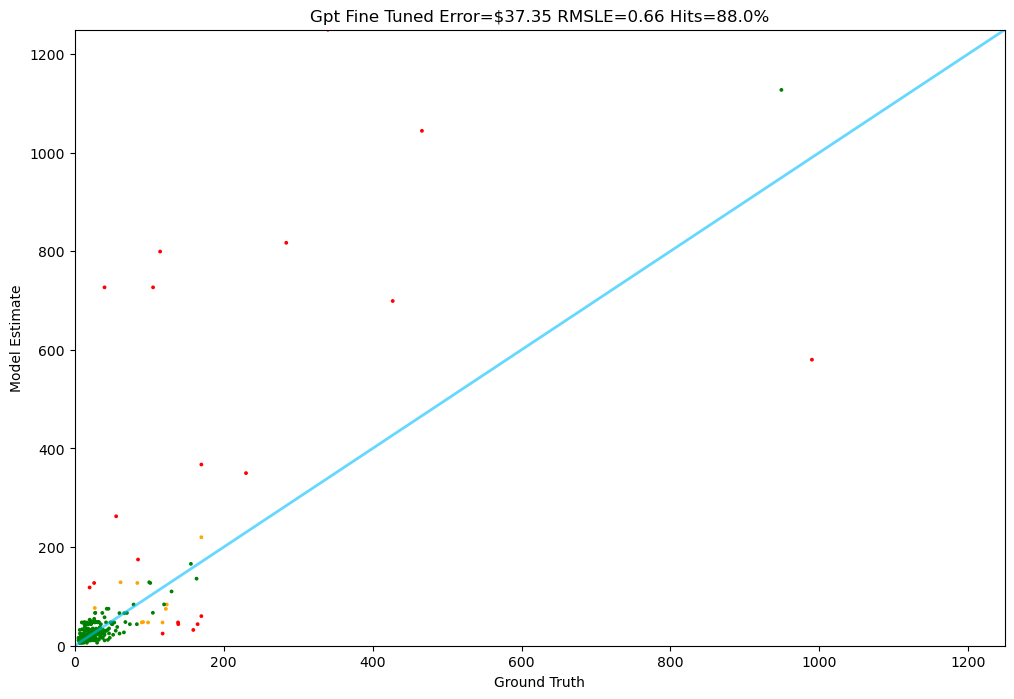

In [47]:
Tester.test(gpt_fine_tuned, test)